## `Stage: 2` - Classification using **`BERT`** + **`ML model`**

In [4]:
import numpy as np
import pandas as pd

# pd.set_option("display.max_rows", None)      # show all rows
# pd.set_option("display.max_columns", None)   # show all columns
# pd.set_option("display.max_colwidth", None)  # don't truncate column text
# pd.set_option("display.expand_frame_repr", False)  # don't wrap output


df_non_regex = pd.read_csv("datasets/bert_df.csv")
df_non_regex.head()

,Unnamed: 0,timestamp,source,log_message,target_label,cluster,regex_label
0,0,27-06-2025 07:20,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,0,NaN
1,1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,1,NaN
2,2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,2,NaN
3,3,12-07-2025 00:24,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,0,NaN
4,4,02-06-2025 18:25,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,0,NaN


In [24]:
# These for LLMs predictions

llm_df = df_non_regex[df_non_regex['source'] == "LegacyCRM"]

llm_df.to_csv("datasets/llm_df.csv")

In [6]:
df_non_legacy = df_non_regex[df_non_regex['source'] != "LegacyCRM"]
df_non_legacy.head()

,Unnamed: 0,timestamp,source,log_message,target_label,cluster,regex_label
0,0,27-06-2025 07:20,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,0,NaN
1,1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,1,NaN
2,2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,2,NaN
3,3,12-07-2025 00:24,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,0,NaN
4,4,02-06-2025 18:25,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,0,NaN


In [7]:
from sentence_transformers import SentenceTransformer

encoder = SentenceTransformer(r"E:\AIML-Projects\HybridLogClassifier-V1\models\transformer_encoder")

embeddings_filtered = encoder.encode(df_non_legacy['log_message'].tolist())
embeddings_filtered.shape

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1903, 384)

In [8]:
X = embeddings_filtered
y = df_non_legacy['target_label'].values

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.dummy import DummyClassifier


models_dist = {
    "LogisticRegression": LogisticRegression(max_iter= 500, n_jobs= -1),
    "RidgeClassifier": RidgeClassifier(max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(ccp_alpha= 0.1),
    "ExtraTreeClassifier": ExtraTreeClassifier(ccp_alpha= 0.1),
    "KNeighborsClassifier": KNeighborsClassifier(n_jobs= -1),
    "GaussianNB": GaussianNB(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators= 200, ccp_alpha= 0.1, n_jobs= -1),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators= 200),
    "BaggingClassifier": BaggingClassifier(n_estimators= 200, n_jobs= -1),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators= 200, ccp_alpha= 0.1),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(max_iter= 200, l2_regularization= 0.1),
    "MLPClassifier": MLPClassifier(max_iter= 500),
    "GaussianProcessClassifier": GaussianProcessClassifier(multi_class= "one_vs_rest"),
    "SVC (RBF kernel)": SVC(probability=True, decision_function_shape= "ovr"),
    "LinearSVC": LinearSVC(multi_class="ovr"),
    "XGBClassifier": XGBClassifier(),
    "XGBRFClassifier": XGBRFClassifier(tree_method="hist", eval_metric="mlogloss"),
    "DummyClassifier": DummyClassifier(strategy= "most_frequent")
}

In [11]:
# Encode
label_encoder = LabelEncoder()
y_train_xgb = label_encoder.fit_transform(y_train)
# y_test_xgb = label_encoder.transform(y_test)

# For comparison with original labels
y_test_bin = label_binarize(y_test, classes=label_encoder.classes_)

classes=label_encoder.classes_
n_classes = len(classes)


====== LogisticRegression ======
                precision    recall  f1-score   support

Critical Error       0.91      1.00      0.95        48
         Error       0.98      0.89      0.93        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      0.99      1.00       123

      accuracy                           0.99       571
     macro avg       0.98      0.98      0.98       571
  weighted avg       0.99      0.99      0.99       571


====== RidgeClassifier ======
                precision    recall  f1-score   support

Critical Error       0.91      1.00      0.95        48
         Error       1.00      0.89      0.94        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      1.00      1.00       123

      accuracy                           0.99       571
     macro avg       0.98      0.9

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is


====== KNeighborsClassifier ======
                precision    recall  f1-score   support

Critical Error       0.96      0.98      0.97        48
         Error       0.98      0.96      0.97        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      1.00      1.00       123

      accuracy                           0.99       571
     macro avg       0.99      0.99      0.99       571
  weighted avg       0.99      0.99      0.99       571


====== GaussianNB ======
                precision    recall  f1-score   support

Critical Error       0.86      1.00      0.92        48
         Error       0.83      0.83      0.83        47
   HTTP Status       1.00      0.97      0.99       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       0.99      0.99      0.99       123

      accuracy                           0.97       571
     macro avg       0.94      0.96  

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is


====== AdaBoostClassifier ======
                precision    recall  f1-score   support

Critical Error       0.91      0.88      0.89        48
         Error       0.88      0.94      0.91        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      1.00      1.00       123

      accuracy                           0.98       571
     macro avg       0.96      0.96      0.96       571
  weighted avg       0.98      0.98      0.98       571


====== BaggingClassifier ======
                precision    recall  f1-score   support

Critical Error       0.94      0.94      0.94        48
         Error       0.94      0.94      0.94        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       0.98      1.00      0.99        49
Security Alert       0.98      0.98      0.98       123

      accuracy                           0.98       571
     macro avg       0.97      0

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is


====== HistGradientBoostingClassifier ======
                precision    recall  f1-score   support

Critical Error       0.94      1.00      0.97        48
         Error       1.00      0.94      0.97        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      1.00      1.00       123

      accuracy                           0.99       571
     macro avg       0.99      0.99      0.99       571
  weighted avg       1.00      0.99      0.99       571


====== MLPClassifier ======
                precision    recall  f1-score   support

Critical Error       0.92      1.00      0.96        48
         Error       1.00      0.91      0.96        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      1.00      1.00       123

      accuracy                           0.99       571
     macro avg       0.9

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

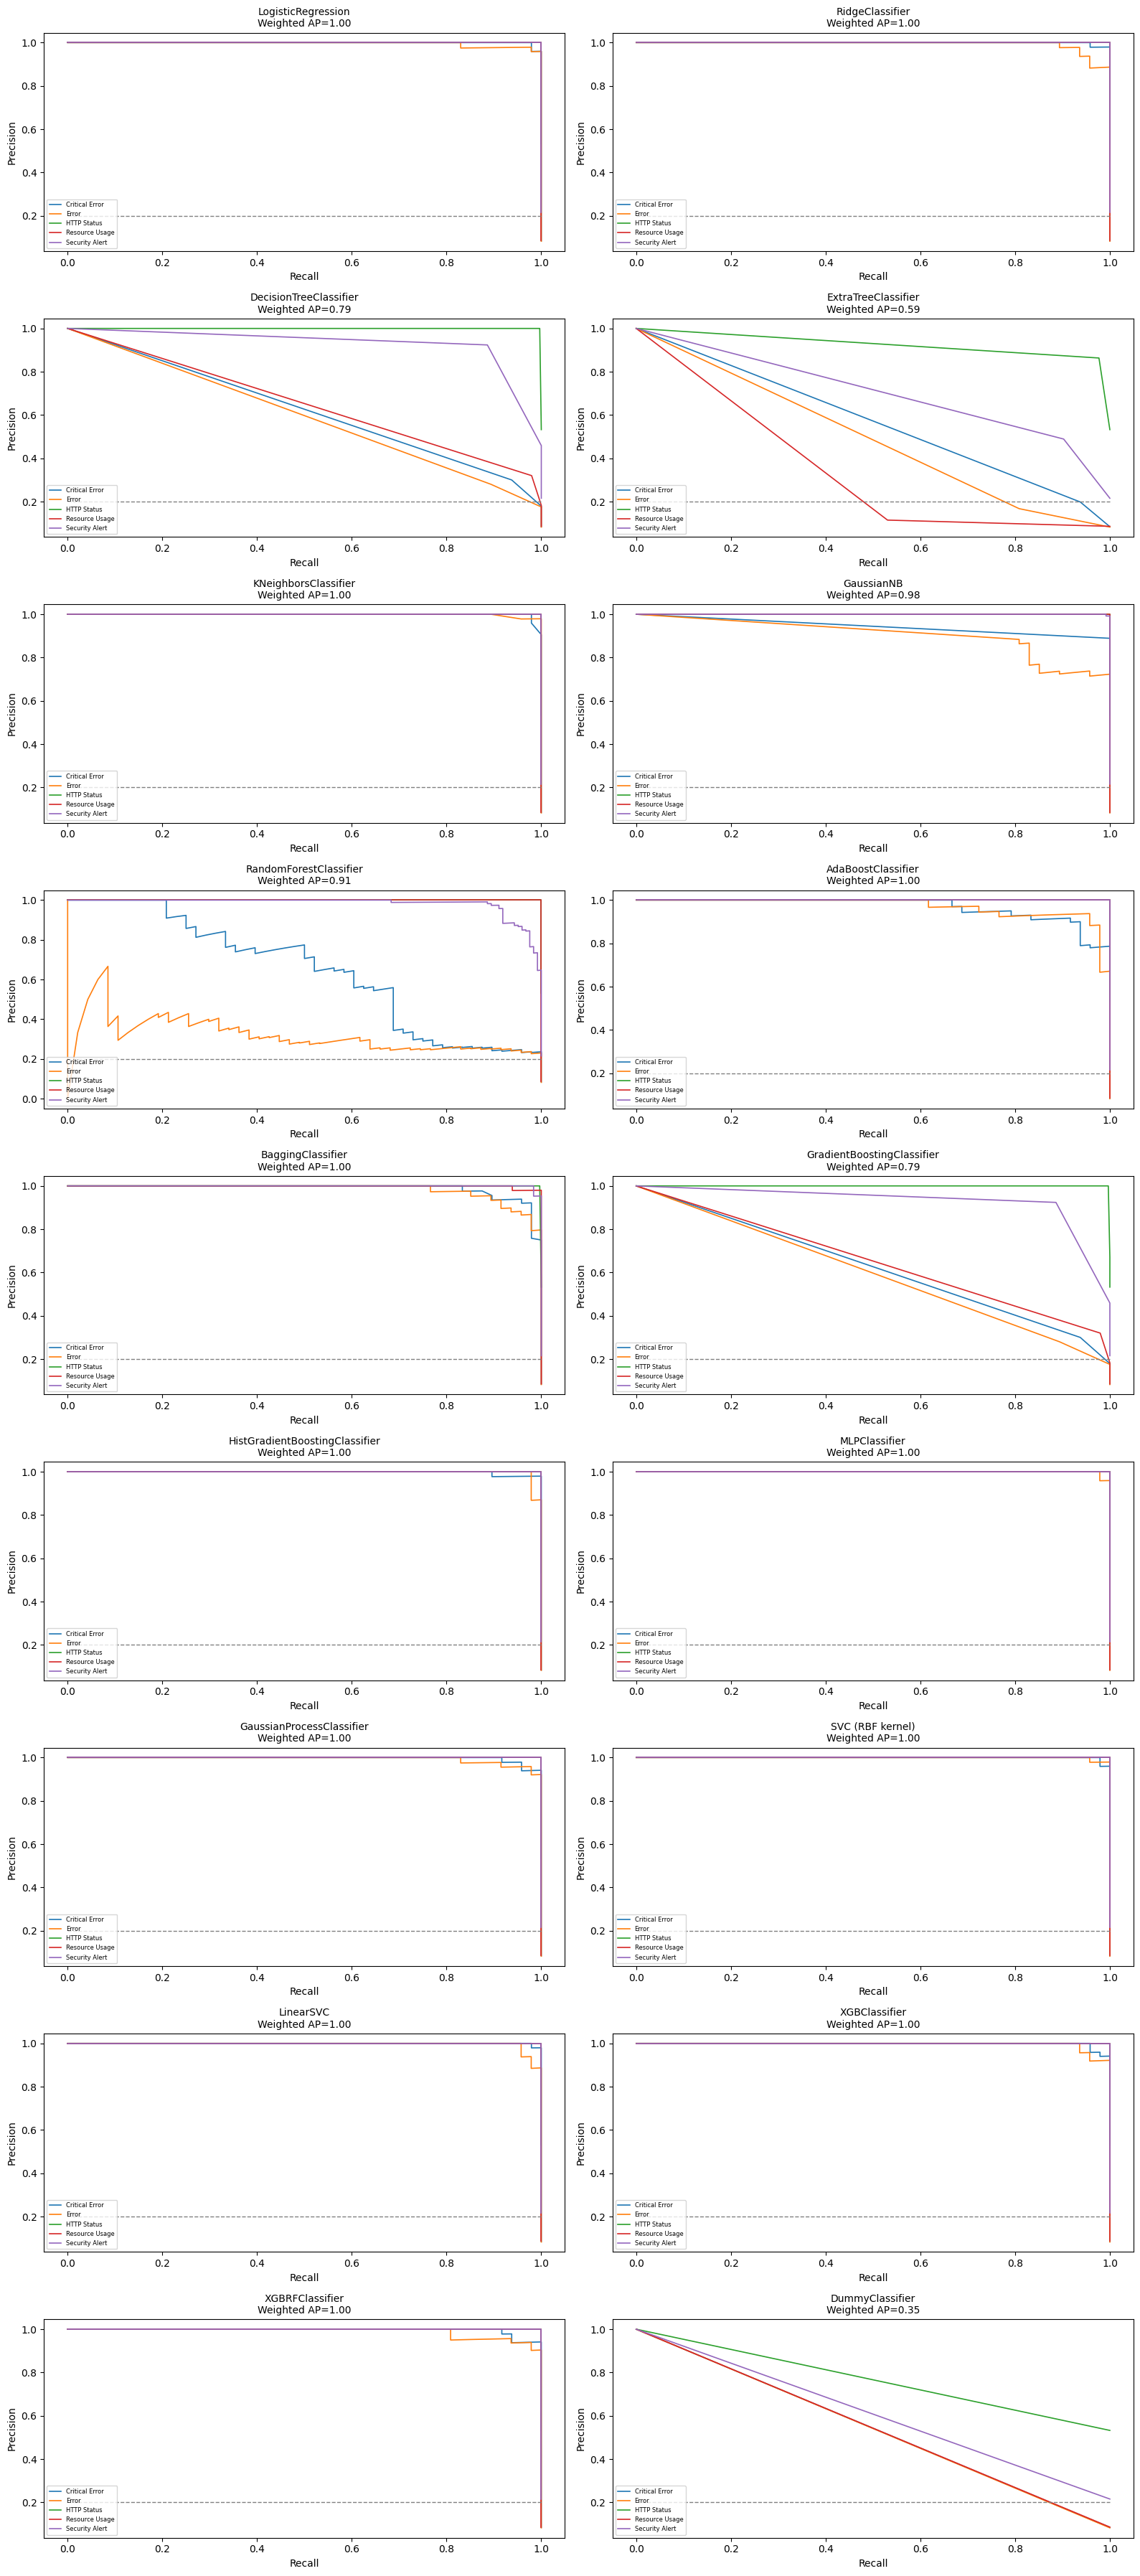

In [12]:

avg_precision_weighted = {}

# Create figure with 9 rows and 2 columns (18 models max)
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(16, 36))
axes = axes.ravel()

for idx, (name, model) in enumerate(models_dist.items()):
    try:
        # === Special handling for XGBoost ===
        if name in ["XGBClassifier", "XGBRFClassifier"]:
            model.fit(X_train, y_train_xgb)
            y_predict = model.predict(X_test)
            y_pred = label_encoder.inverse_transform(y_predict)
        else:
            if name == "LinearSVC":
                model = OneVsRestClassifier(model)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        print(f"\n====== {name} ======")
        print(classification_report(y_test, y_pred))

        # === Get probability/decision scores ===
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:
            y_score = model.decision_function(X_test)

        # Binary classification fix
        if y_score.ndim == 1:
            y_score = np.column_stack([1 - y_score, y_score])

        # === Weighted Average Precision ===
        avg_prec = average_precision_score(y_test_bin, y_score, average="weighted")
        avg_precision_weighted[name] = avg_prec

        # === Plot Precision-Recall Curves ===
        ax = axes[idx]
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ax.plot(recall, precision, lw=1.2, label=f"{classes[i]}")

        # Baseline: prevalence of positive class
        prevalence = y_test_bin.mean()
        ax.hlines(prevalence, 0, 1, colors="gray", linestyles="--", lw=1)

        ax.set_title(f"{name}\nWeighted AP={avg_prec:.2f}", fontsize=10)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(fontsize=6, loc="lower left")

    except Exception as e:
        print(f"Skipping {name}: {e}")

plt.tight_layout()
plt.show()

In [13]:
fig.savefig('precision_recall_curve')

In [14]:
print("\n=== AUC Scores by Model (sorted) ===")
for model, score in sorted(avg_precision_weighted.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.4f}")


=== AUC Scores by Model (sorted) ===
MLPClassifier: 0.9999
SVC (RBF kernel): 0.9999
LinearSVC: 0.9997
KNeighborsClassifier: 0.9996
HistGradientBoostingClassifier: 0.9996
LogisticRegression: 0.9996
XGBClassifier: 0.9995
RidgeClassifier: 0.9993
GaussianProcessClassifier: 0.9992
XGBRFClassifier: 0.9988
BaggingClassifier: 0.9964
AdaBoostClassifier: 0.9950
GaussianNB: 0.9790
RandomForestClassifier: 0.9110
GradientBoostingClassifier: 0.7933
DecisionTreeClassifier: 0.7931
ExtraTreeClassifier: 0.5924
DummyClassifier: 0.3511


### ✅ Conclusion

- Based on the model evaluation so far, `HistGradientBoostingClassifier` has performed exceptionally well, achieving both high accuracy and maintaining scalability.

- Compared to other models, it strikes the right balance between speed, generalization, and robustness on the dataset.

- Given its performance and efficiency, `HistGradientBoostingClassifier` can be considered a strong candidate for deployment in scenarios where fast and scalable solutions are required.

In [33]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier, OutputCodeClassifier
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define base classifier
clf = LogisticRegression()  # saga works with l1/l2/elasticnet

# 2. Param grid (valid for LogisticRegression)
param_distributions = [
    # saga: supports l1, l2, elasticnet
    {
        "solver": ["saga"],
        "penalty": ["l1", "l2", "elasticnet"],
        "C": [1e-3, 1e-2, 0.1, 1, 10],
        "l1_ratio": [0.0, 0.5, 1.0],  # only for elasticnet
        "class_weight": [None, "balanced"],
    },
    # # liblinear: supports l1, l2
    # {
    #     "solver": ["liblinear"],
    #     "penalty": ["l1", "l2"],
    #     "C": [1e-3, 0.1, 1, 10],
    #     "class_weight": [None, "balanced"],
    #     "dual": [False, True],  # only works for l2
    # },
    # # lbfgs/newton-cg/sag: only l2
    # {
    #     "solver": ["lbfgs", "newton-cg", "sag"],
    #     "penalty": ["l2"],
    #     "C": [1e-3, 0.1, 1, 10, 100],
    #     "class_weight": [None, "balanced"],
    # }
]


In [34]:
from sklearn.model_selection import RandomizedSearchCV

results = []
for grid in param_distributions:
    search = RandomizedSearchCV(
        LogisticRegression(max_iter=1000),
        grid,
        n_iter=20,
        cv=3,
        scoring="f1_weighted",
        n_jobs=2,  # <= safer than -1
        random_state=42,
        verbose=2
    )
    search.fit(X_train, y_train)
    results.append(search)
    print("Best params:", search.best_params_)
    print("Best score:", search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best params: {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': 0.0, 'class_weight': 'balanced', 'C': 10}
Best score: 0.9977465917986352


c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [36]:
# 4. Use best model
best_params = search.best_params_
base_model = LogisticRegression(**best_params,max_iter=1000)
base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


                precision    recall  f1-score   support

Critical Error       0.91      1.00      0.95        48
         Error       1.00      0.89      0.94        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      1.00      1.00       123

      accuracy                           0.99       571
     macro avg       0.98      0.98      0.98       571
  weighted avg       0.99      0.99      0.99       571



c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


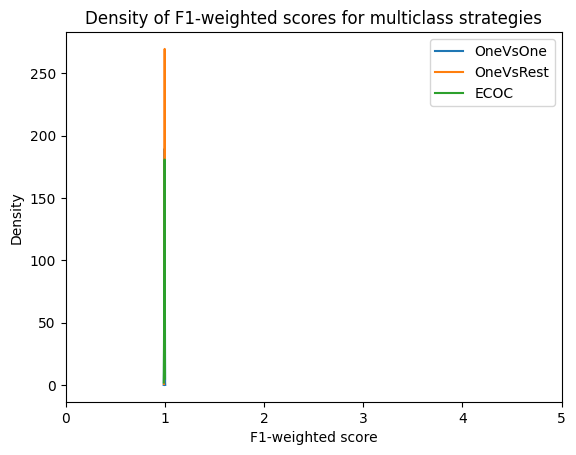

In [39]:
# 5. Compare multiclass strategies with tuned model
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)

ovo_model = OneVsOneClassifier(base_model)

ovr_model = OneVsRestClassifier(base_model)
ecoc_model = OutputCodeClassifier(base_model, code_size=2, random_state=42)

cv_results_ovo = cross_validate(ovo_model, X, y, cv=cv, n_jobs=-1, scoring="f1_weighted")
cv_results_ovr = cross_validate(ovr_model, X, y, cv=cv, n_jobs=-1, scoring="f1_weighted")
cv_results_ecoc = cross_validate(ecoc_model, X, y, cv=cv, n_jobs=-1, scoring="f1_weighted")

scores = pd.DataFrame(
    {
        "OneVsOne": cv_results_ovo["test_score"],
        "OneVsRest": cv_results_ovr["test_score"],
        "ECOC": cv_results_ecoc["test_score"],
    }
)

ax = scores.plot.kde(legend=True)
ax.set_xlabel("F1-weighted score")
ax.set_xlim([0, 5])
ax.set_title("Density of F1-weighted scores for multiclass strategies")
plt.show()

In [40]:
# import joblib

# joblib.dump(ovr_model, "../models/final_model.joblib")

In [41]:
# ovr_model.fit(X_train, y_train)
# y_score = ovr_model.predict_proba(X_test)
# y_pred = ovr_model.predict(X_test)
# print(classification_report(y_test, y_pred))
# print(y_score[:5])

In [42]:
import joblib

joblib.dump(base_model, "../models/final_model.joblib")

['../models/final_model.joblib']